Pip install shap

____

Loading model from model.h5...


Generating explanations for sample images...
Found classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Successfully found 4 sample images
Background data shape: (3, 128, 128, 3)
Creating SHAP explainer...
Explaining image 1/4: mri-dataset/Testing/meningioma/Te-me_0068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Predicted class index: 0
Predicted class name: glioma
SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (1, 128, 128, 3, 4)


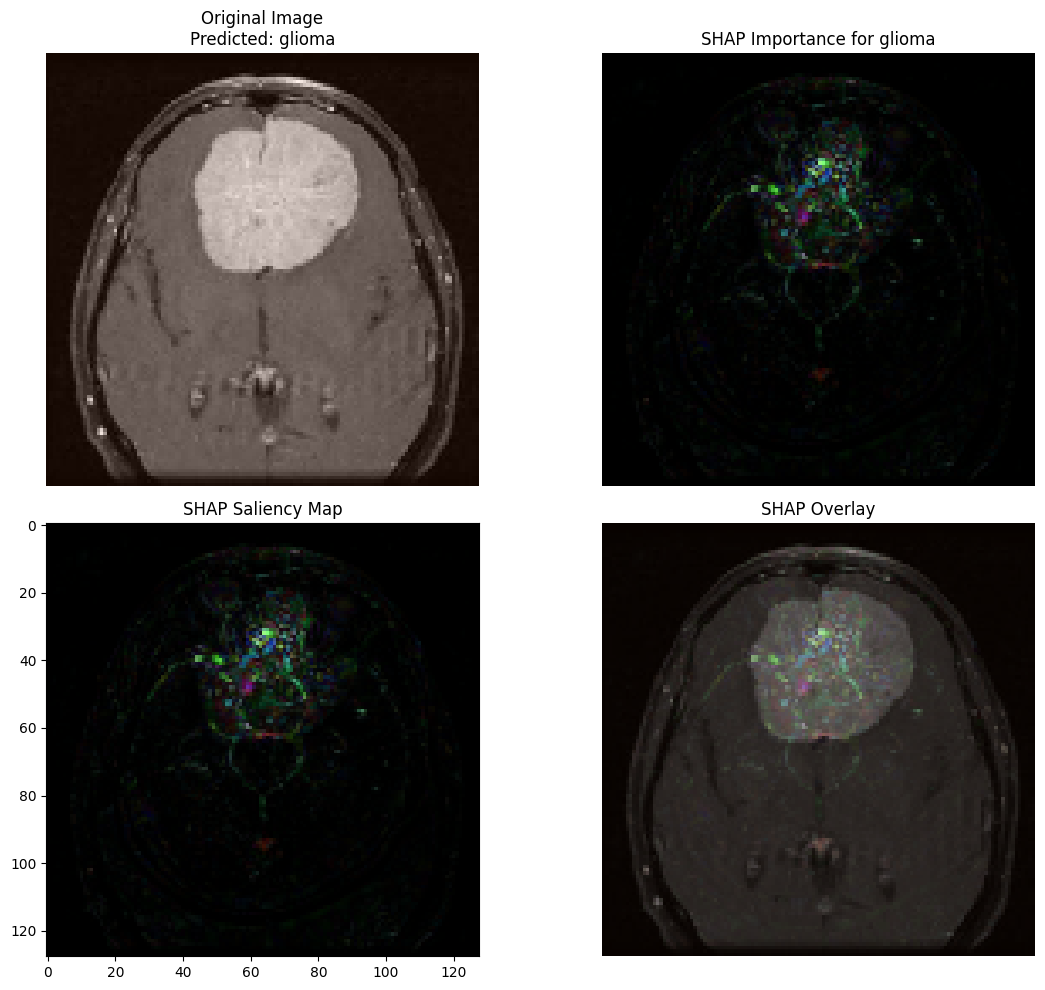

Explaining image 2/4: mri-dataset/Testing/pituitary/Te-pi_0122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class index: 1
Predicted class name: meningioma
SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (1, 128, 128, 3, 4)


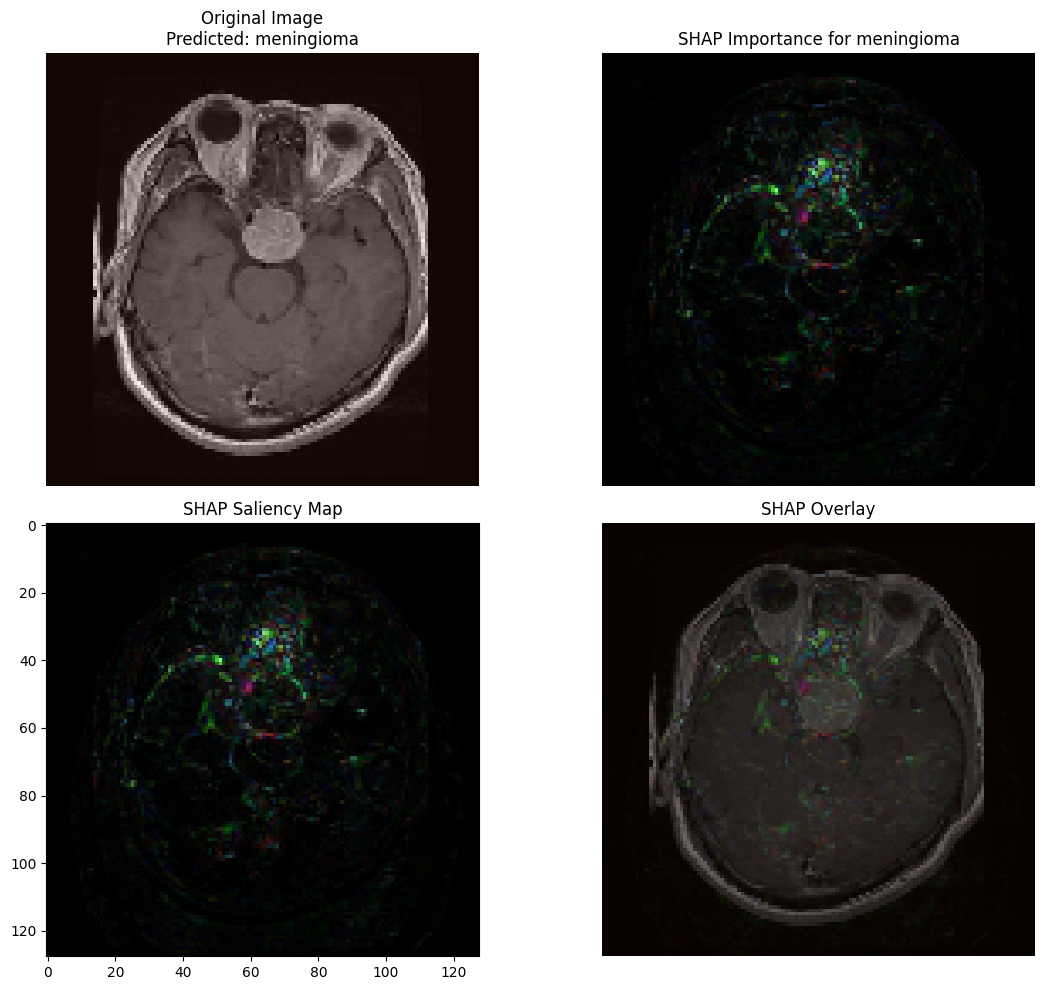

Explaining image 3/4: mri-dataset/Testing/glioma/Te-gl_0263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class index: 0
Predicted class name: glioma
SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (1, 128, 128, 3, 4)


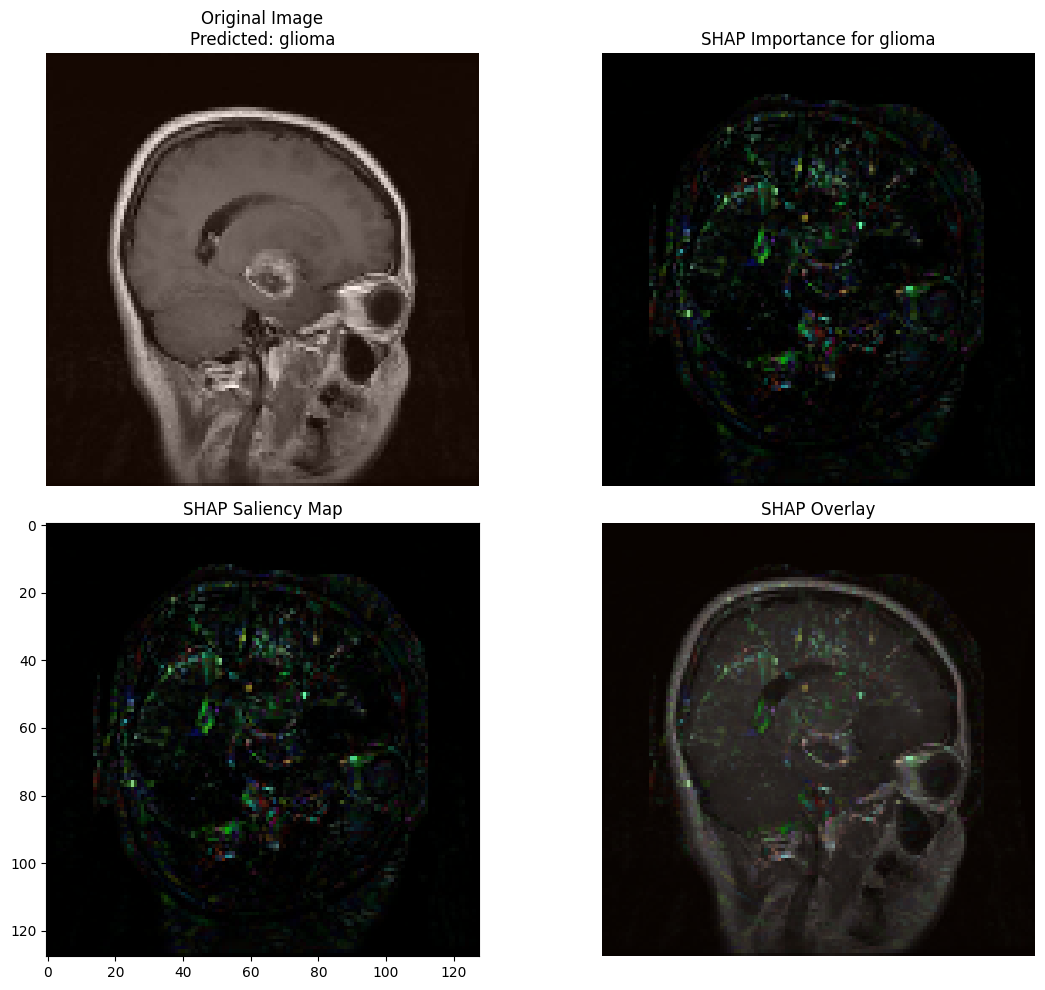

Explaining image 4/4: mri-dataset/Testing/notumor/Te-no_0055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class index: 3
Predicted class name: pituitary
SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (1, 128, 128, 3, 4)


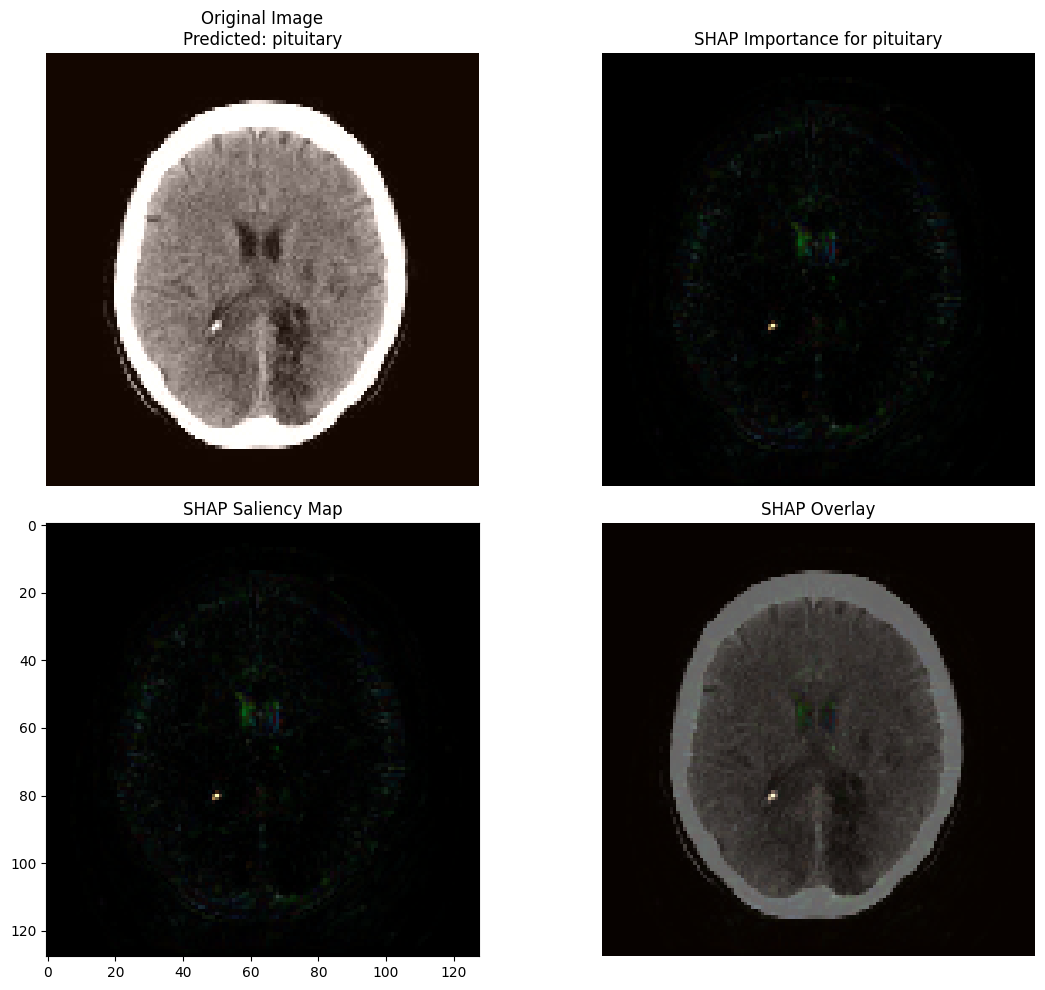

Analyzing layer activations for mri-dataset/Testing/meningioma/Te-me_0088.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


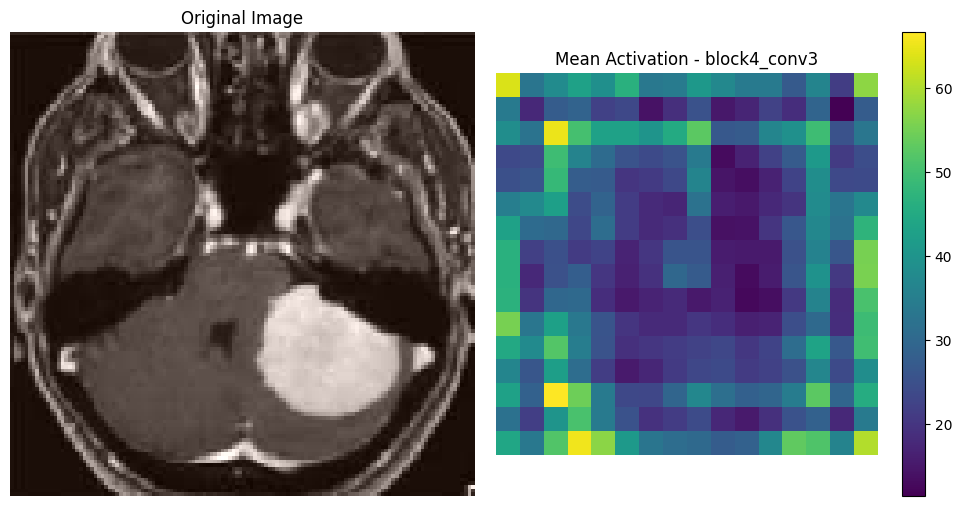

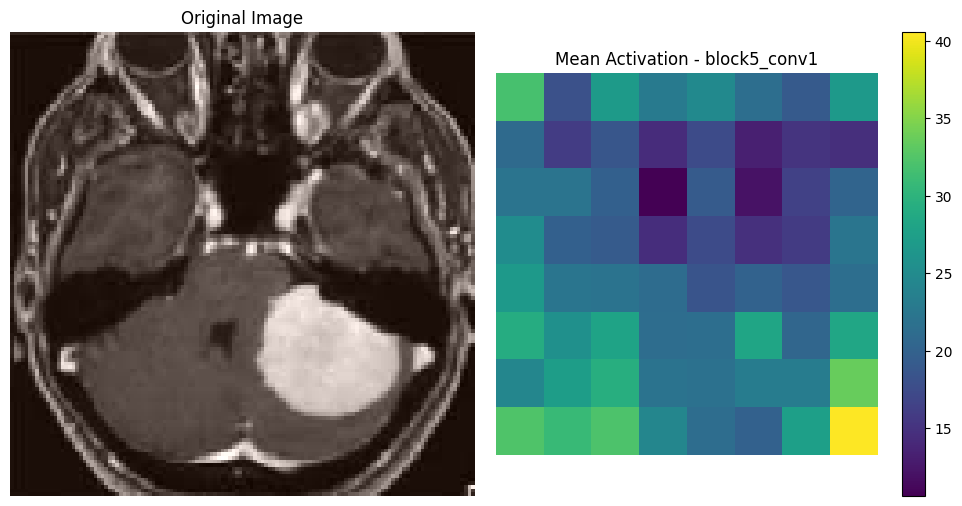

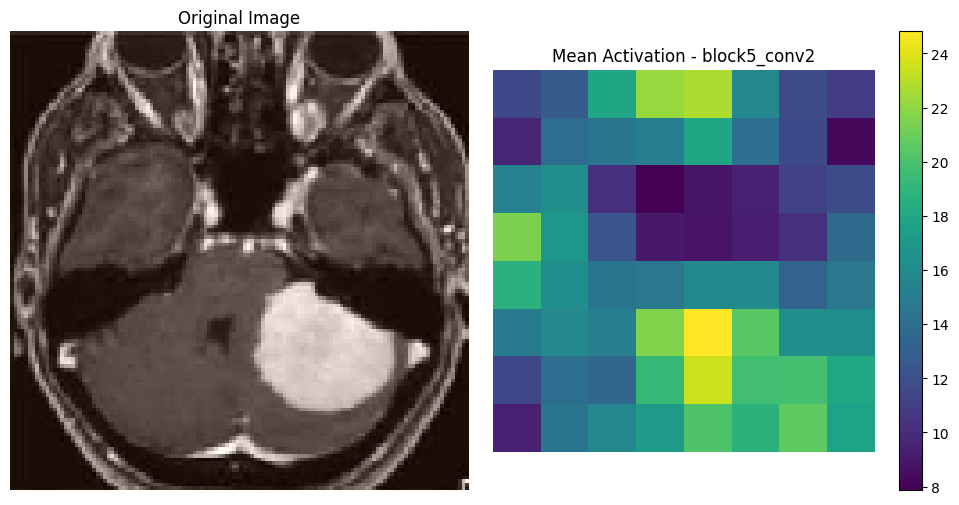

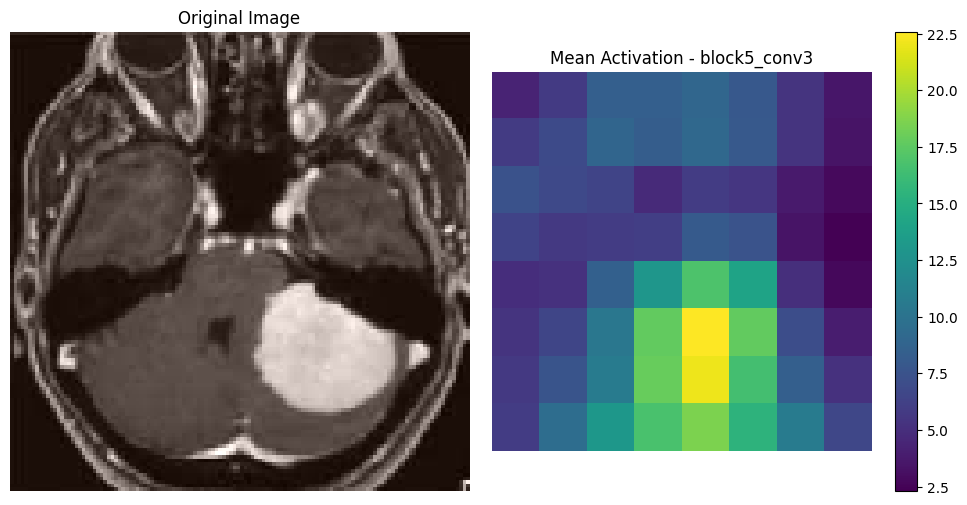

SHAP analysis complete!


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import os
import random

# Load the pre-trained model first
def load_model(model_path):
    """Load the saved model from disk."""
    print(f"Loading model from {model_path}...")
    return tf.keras.models.load_model(model_path)

def prepare_image_for_shap(image_path, target_size=(128, 128)):
    """Load and preprocess an image for the VGG16 model."""
    img = load_img(image_path, target_size=target_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  # VGG16 preprocessing
    return x

def get_sample_images(data_dir, num_samples=10, target_size=(128, 128)):
    """Get a sample of images from the dataset."""
    classes = os.listdir(data_dir)
    sample_paths = []
    sample_labels = []
    
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        # Take a few samples from each class
        samples_per_class = max(1, num_samples // len(classes))
        if len(image_files) > 0:  # Only sample if there are images
            class_samples = random.sample(image_files, min(samples_per_class, len(image_files)))
            
            for img_file in class_samples:
                img_path = os.path.join(class_dir, img_file)
                sample_paths.append(img_path)
                sample_labels.append(class_idx)
    
    return sample_paths, sample_labels

def create_shap_explainer(model, background_images=None):
    """Create a SHAP DeepExplainer for the model."""
    # If no background images provided, create a black reference image
    if background_images is None:
        background_images = np.zeros((1, 128, 128, 3))
    
    # Create explainer
    explainer = shap.DeepExplainer(model, background_images)
    return explainer

def explain_prediction(explainer, image, class_names):
    """Generate and visualize SHAP values for an image."""
    # Calculate SHAP values
    shap_values = explainer.shap_values(image)
    
    # Get predicted class
    prediction = np.argmax(model.predict(image)[0])
    predicted_class = class_names[prediction]
    
    # Debug information
    print(f"Predicted class index: {prediction}")
    print(f"Predicted class name: {predicted_class}")
    print(f"SHAP values type: {type(shap_values)}")
    
    # Handle different formats of SHAP values
    if isinstance(shap_values, list):
        print(f"SHAP values is a list of length {len(shap_values)}")
        # Check if we have enough elements in the list
        if prediction < len(shap_values):
            shap_for_predicted_class = shap_values[prediction]
        else:
            # Use the first element if prediction index is out of range
            print(f"Warning: Prediction index {prediction} is out of range for SHAP values list with length {len(shap_values)}")
            shap_for_predicted_class = shap_values[0]
    else:
        # If not a list, assume it's a single array
        print(f"SHAP values shape: {shap_values.shape}")
        shap_for_predicted_class = shap_values
    
    # Plot the SHAP values
    plt.figure(figsize=(12, 10))
    
    # Original image
    plt.subplot(2, 2, 1)
    img_display = (image[0] + 123.68) / 255  # Reverse VGG preprocessing for display
    img_display = np.clip(img_display, 0, 1)
    plt.imshow(img_display)
    plt.title(f"Original Image\nPredicted: {predicted_class}")
    plt.axis('off')
    
    # Modified visualization for SHAP values based on format
    plt.subplot(2, 2, 2)
    
    # Try to visualize based on the shape of the shap values
    try:
        # If it's shaped like the input image
        if shap_for_predicted_class.shape[1:3] == image.shape[1:3]:
            # Calculate the absolute sum across the color channels
            abs_shap = np.abs(shap_for_predicted_class[0]).sum(axis=-1)
            # Normalize the values
            if abs_shap.max() > 0:
                abs_shap = abs_shap / abs_shap.max()
            plt.imshow(abs_shap, cmap='hot')
            plt.title(f"SHAP Importance for {predicted_class}")
        else:
            # For other shapes, just show the first element
            plt.text(0.5, 0.5, "SHAP values have incompatible shape for visualization",
                    ha='center', va='center')
            plt.title("SHAP Visualization Not Available")
    except Exception as e:
        print(f"Error creating SHAP visualization: {e}")
        plt.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center')
    
    plt.axis('off')
    
    # Create a saliency map using the absolute values
    plt.subplot(2, 2, 3)
    try:
        if shap_for_predicted_class.shape[1:3] == image.shape[1:3]:
            # Similar calculation but stored for overlay
            shap_magnitude = np.abs(shap_for_predicted_class).sum(axis=-1)
            if shap_magnitude.max() > 0:
                shap_magnitude = shap_magnitude / shap_magnitude.max()  # Normalize to [0,1]
            plt.imshow(shap_magnitude[0], cmap='hot')
            plt.title("SHAP Saliency Map")
            
            # Overlay the saliency map on the original image
            plt.subplot(2, 2, 4)
            plt.imshow(img_display)
            plt.imshow(shap_magnitude[0], cmap='hot', alpha=0.6)
            plt.title("SHAP Overlay")
        else:
            plt.subplot(2, 2, 3)
            plt.text(0.5, 0.5, "Saliency map unavailable", ha='center', va='center')
            plt.title("SHAP Saliency Map Not Available")
            
            plt.subplot(2, 2, 4)
            plt.imshow(img_display)
            plt.title("Original Image (Overlay Not Available)")
    except Exception as e:
        print(f"Error creating saliency map: {e}")
        plt.subplot(2, 2, 3)
        plt.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center')
        plt.subplot(2, 2, 4)
        plt.imshow(img_display)
        plt.title("Original Image (Overlay Not Available)")
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def explain_multiple_images(model, data_dir, num_samples=5):
    """Generate SHAP explanations for multiple sample images."""
    # Get class names
    class_names = sorted(os.listdir(data_dir))
    print(f"Found classes: {class_names}")
    
    # Get sample images
    sample_paths, sample_labels = get_sample_images(data_dir, num_samples)
    
    if not sample_paths:
        print("No sample images found. Please check your data directory.")
        return
    
    print(f"Successfully found {len(sample_paths)} sample images")
        
    # Prepare background data for the explainer (first few images)
    background_data = np.vstack([prepare_image_for_shap(path) for path in sample_paths[:min(3, len(sample_paths))]])
    print(f"Background data shape: {background_data.shape}")
    
    # Special handling for binary classification models
    num_classes = len(class_names)
    if num_classes == 2 and model.output_shape[1] == 1:
        print("Detected binary classification model with sigmoid output")
        # For binary models with sigmoid output, we need to convert to a 2-class output
        # by creating a wrapper model
        try:
            orig_output = model.output
            # Create a lambda layer that transforms sigmoid output [p] to softmax-like [1-p, p]
            binary_output = tf.keras.layers.Lambda(
                lambda x: tf.concat([1-x, x], axis=-1)
            )(orig_output)
            # Create a new model with the same input but binary_output
            binary_model = tf.keras.Model(inputs=model.input, outputs=binary_output)
            print("Created wrapper model for binary classification")
            model_to_use = binary_model
        except Exception as e:
            print(f"Error creating binary wrapper model: {e}")
            print("Using original model")
            model_to_use = model
    else:
        model_to_use = model
    
    # Create explainer
    print("Creating SHAP explainer...")
    explainer = create_shap_explainer(model_to_use, background_data)
    
    # Generate explanations for each sample image
    for i, img_path in enumerate(sample_paths):
        print(f"Explaining image {i+1}/{len(sample_paths)}: {img_path}")
        image = prepare_image_for_shap(img_path)
        explain_prediction(explainer, image, class_names)

def compute_feature_importance(model, data_dir, num_samples=20):
    """Compute overall feature importance across multiple samples."""
    # Get class names
    class_names = sorted(os.listdir(data_dir))
    
    # Get sample images
    sample_paths, sample_labels = get_sample_images(data_dir, num_samples)
    
    if not sample_paths:
        print("No sample images found. Please check your data directory.")
        return
        
    # Prepare sample data
    sample_data = np.vstack([prepare_image_for_shap(path) for path in sample_paths])
    
    # Create background data (subset of samples)
    background_data = sample_data[:min(5, len(sample_data))]
    
    # Special handling for binary classification models
    num_classes = len(class_names)
    if num_classes == 2 and model.output_shape[1] == 1:
        print("Detected binary classification model with sigmoid output")
        # Create a wrapper model as in explain_multiple_images
        try:
            orig_output = model.output
            binary_output = tf.keras.layers.Lambda(
                lambda x: tf.concat([1-x, x], axis=-1)
            )(orig_output)
            binary_model = tf.keras.Model(inputs=model.input, outputs=binary_output)
            model_to_use = binary_model
        except Exception as e:
            print(f"Error creating binary wrapper model: {e}")
            model_to_use = model
    else:
        model_to_use = model
    
    # Create explainer
    explainer = create_shap_explainer(model_to_use, background_data)
    
    try:
        # Calculate SHAP values for all samples
        all_shap_values = explainer.shap_values(sample_data)
        
        # Handle different formats of SHAP values
        if isinstance(all_shap_values, list):
            print(f"SHAP returned a list of length {len(all_shap_values)}")
            channel_importance = []
            
            for class_idx in range(min(len(class_names), len(all_shap_values))):
                # Get mean absolute SHAP values for this class
                mean_abs_shap = np.abs(all_shap_values[class_idx]).mean(axis=0)
                
                # Sum across spatial dimensions to get channel importance
                channel_imp = mean_abs_shap.sum(axis=(0, 1))
                channel_importance.append(channel_imp)
        else:
            print(f"SHAP returned an array of shape {all_shap_values.shape}")
            # For a single array, split by classes if possible
            if len(all_shap_values.shape) >= 2 and all_shap_values.shape[1] == len(class_names):
                channel_importance = []
                for class_idx in range(len(class_names)):
                    class_shap = all_shap_values[:, class_idx, ...]
                    mean_abs_shap = np.abs(class_shap).mean(axis=0)
                    channel_imp = mean_abs_shap.sum(axis=(0, 1))
                    channel_importance.append(channel_imp)
            else:
                # If we can't split by classes, just use the mean
                mean_abs_shap = np.abs(all_shap_values).mean(axis=0)
                channel_imp = mean_abs_shap.sum(axis=(0, 1))
                channel_importance = [channel_imp] * len(class_names)
        
        # Plot channel importance for each class
        plt.figure(figsize=(14, 8))
        x = np.arange(3)  # 3 channels (R, G, B)
        width = 0.8 / len(class_names)
        
        for i, (class_name, imp) in enumerate(zip(class_names, channel_importance)):
            plt.bar(x + i*width - 0.4, imp, width, label=class_name)
        
        plt.xlabel('Color Channel')
        plt.ylabel('Importance (mean |SHAP value|)')
        plt.title('Color Channel Importance by Class')
        plt.xticks(x, ['Red', 'Green', 'Blue'])
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"Error computing feature importance: {e}")
        print("Skipping feature importance visualization")

def analyze_layer_activations(model, image_path, target_size=(128, 128)):
    """Analyze the activations of intermediate layers."""
    # Load and preprocess the image
    image = prepare_image_for_shap(image_path, target_size)
    
    # For a Sequential model with a VGG16 base, find the base model
    try:
        # This assumes your model structure has VGG16 as the first layer
        base_model = model.layers[0]
        
        # Try to find convolutional layers
        conv_layers = []
        for i, layer in enumerate(base_model.layers):
            if 'conv' in layer.name:
                conv_layers.append((i, layer.name))
        
        if not conv_layers:
            print("No convolutional layers found in the base model.")
            return
            
        # Select the last few convolutional layers
        layers_to_analyze = [name for _, name in conv_layers[-4:]]
        
        # Create intermediate models for different layers
        layer_outputs = []
        layer_names = []
        
        for layer in base_model.layers:
            if layer.name in layers_to_analyze:
                intermediate_model = tf.keras.Model(inputs=base_model.input, 
                                                outputs=layer.output)
                layer_outputs.append(intermediate_model.predict(image))
                layer_names.append(layer.name)
    
    except Exception as e:
        print(f"Error accessing model layers: {e}")
        print("Using a simplified approach for layer analysis...")
        
        # Create a new model that outputs intermediate activations
        layer_outputs = []
        layer_names = []
        
        # Try to get some intermediate layers from the model
        for i, layer in enumerate(model.layers):
            if i > 0 and i < len(model.layers) - 1:  # Skip input and output layers
                try:
                    intermediate_model = tf.keras.Model(inputs=model.input, 
                                                     outputs=layer.output)
                    output = intermediate_model.predict(image)
                    layer_outputs.append(output)
                    layer_names.append(f"Layer {i}")
                except:
                    pass
    
    # Visualize the activations for each layer we found
    for i, (name, act) in enumerate(zip(layer_names, layer_outputs)):
        # Handle different activation shapes
        if len(act.shape) == 4:  # Convolutional layer (batch, height, width, channels)
            # Compute mean activation across channels
            mean_act = np.mean(act[0], axis=-1)
            
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow((image[0] + 123.68) / 255)
            plt.title("Original Image")
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(mean_act, cmap='viridis')
            plt.title(f"Mean Activation - {name}")
            plt.axis('off')
            plt.colorbar()
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"Layer {name} has shape {act.shape}, skipping visualization")

# Main execution
if __name__ == "__main__":
    # Define paths
    model_path = "model.h5"  # Path to your saved model
    train_dir = "mri-dataset/Testing"  # Update with your actual path
    
    # Load the model first
    model = load_model(model_path)
    
    # Example usage:
    # 1. Explain predictions for multiple images
    print("Generating explanations for sample images...")
    explain_multiple_images(model, train_dir, num_samples=5)
    
    # 2. Compute feature importance
    # print("Computing feature importance...")
    # compute_feature_importance(model, train_dir)
    
    # 3. Analyze a specific image in detail
    sample_paths, _ = get_sample_images(train_dir, 1)
    if sample_paths:
        print(f"Analyzing layer activations for {sample_paths[0]}...")
        analyze_layer_activations(model, sample_paths[0])
    
    print("SHAP analysis complete!")